# Apartado 3  Práctica 3  
# Transferencia de modelos y ajste fino con ResNet50 para la base de datos Caltech-UCSD  

Autora: Blanca Cano Camarero 
  
Trabajaremos con el conjunto de datos Caltech-UCSD. Este conjunto de datos se compone de 6033 imágenes de 200 especies de pájaros.
Tiene, por tanto, 200 clases, con 3000 imágenes en el conjunto de entrenamiento y 3033 en el de prueba. De nuevo, se dejará un 10% del conjunto de entrenamiento para validación. Para leer el conjunto de datos usar las funciones dadas.
Usaremos el modelo de red ResNet50 ya pre-entrenada con ImageNet y que está disponible en Keras. 

## Ejercicio 1 

1.- Usar ResNet50 como un extractor de características para los datos de Caltech-UCSD disponible en http://www.vision.caltech.edu/visipedia/CUB-200.html Para ello eliminaremos al menos las dos últimas capas del modelo descargado, añadiremos algunas capas de cálculo adicional y la capa de salida. En concreto realizar los siguientes experimentos:


### A a) Adaptar el modelo ResNet a los datos de Caltech-UCSD y estimar su desempeño con esos datos  



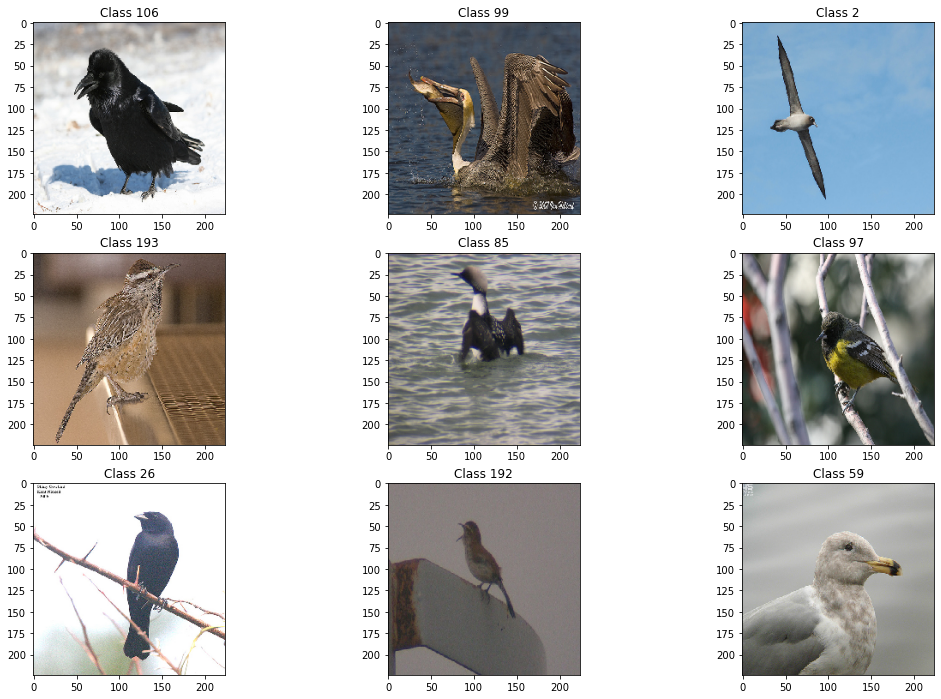

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels.h5: None -- [Errno 8] nodename nor servname provided, or not known

In [28]:
# Tarda un minuto la ejecución 
#########################################################################
################### OBTENER LA BASE DE DATOS ############################
#########################################################################

# Descargar las imágenes de http://www.vision.caltech.edu/visipedia/CUB-200.html
# Descomprimir el fichero.
# Descargar también el fichero list.tar.gz, descomprimirlo y guardar los ficheros
# test.txt y train.txt dentro de la carpeta de imágenes anterior. Estos 
# dos ficheros contienen la partición en train y test del conjunto de datos.

##### EN CASO DE USAR COLABORATORY
# Sube tanto las imágenes como los ficheros text.txt y train.txt a tu drive.
# Después, ejecuta esta celda y sigue las instrucciones para montar 
# tu drive en colaboratory.
#from google.colab import drive
#drive.mount('/content/drive')

#########################################################################
################ CARGAR LAS LIBRERÍAS NECESARIAS ########################
#########################################################################

# Terminar de rellenar este bloque con lo que vaya haciendo falta

# Importar librerías necesarias
import numpy as np
import keras
import tensorflow.keras.utils as np_utils
from keras.preprocessing.image import load_img,img_to_array, ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D

# Importar el modelo ResNet50 y su respectiva función de preprocesamiento,
# que es necesario pasarle a las imágenes para usar este modelo
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import matplotlib.pyplot as plt
# Importar el optimizador a usar
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
#########################################################################
################## FUNCIÓN PARA LEER LAS IMÁGENES #######################
#########################################################################

# Dado un fichero train.txt o test.txt y el path donde se encuentran los
# ficheros y las imágenes, esta función lee las imágenes
# especificadas en ese fichero y devuelve las imágenes en un vector y 
# sus clases en otro.

def leerImagenes(vec_imagenes, path):
  clases = np.array([img.split('/')[0] for img in vec_imagenes])
  imagenes = np.array([img_to_array(load_img(path + "/" + img, 
                                             target_size = (224, 224))) 
                       for img in vec_imagenes])
  return imagenes, clases

#########################################################################
############# FUNCIÓN PARA CARGAR EL CONJUNTO DE DATOS ##################
#########################################################################

# Usando la función anterior, y dado el path donde se encuentran las
# imágenes y los archivos "train.txt" y "test.txt", devuelve las 
# imágenes y las clases de train y test para usarlas con keras
# directamente.

def cargarDatos(path_list, path_images):
  '''path list : los archivos de train.txt y test.txt 
    path_images: es dónde se encuentran las imágenes

  si ambas están en la misma carpeta entontes path_list debe hacerse path_images
  '''
  # Cargamos los ficheros
  train_images = np.loadtxt(path_list + "/train.txt", dtype = str)
  test_images = np.loadtxt(path_list  + "/test.txt", dtype = str)
  
  # Leemos las imágenes con la función anterior
  train, train_clases = leerImagenes(train_images, path_images)
  test, test_clases = leerImagenes(test_images, path_images)
  
  # Pasamos los vectores de las clases a matrices 
  # Para ello, primero pasamos las clases a números enteros
  clases_posibles = np.unique(np.copy(train_clases))
  for i in range(len(clases_posibles)):
    train_clases[train_clases == clases_posibles[i]] = i
    test_clases[test_clases == clases_posibles[i]] = i

  # Después, usamos la función to_categorical()
  train_clases = np_utils.to_categorical(train_clases, 200)
  test_clases = np_utils.to_categorical(test_clases, 200)
  
  # Barajar los datos
  train_perm = np.random.permutation(len(train))
  train = train[train_perm]
  train_clases = train_clases[train_perm]

  test_perm = np.random.permutation(len(test))
  test = test[test_perm]
  test_clases = test_clases[test_perm]

  # normalizazamos los valores
  train = train.astype('float32')
  test = test.astype('float32')
  train /= 255
  test /= 255
  
  
  return train, train_clases, test, test_clases

#########################################################################
######## FUNCIÓN PARA OBTENER EL ACCURACY DEL CONJUNTO DE TEST ##########
#########################################################################

# Esta función devuelve el accuracy de un modelo, definido como el 
# porcentaje de etiquetas bien predichas frente al total de etiquetas.
# Como parámetros es necesario pasarle el vector de etiquetas verdaderas
# y el vector de etiquetas predichas, en el formato de keras (matrices
# donde cada etiqueta ocupa una fila, con un 1 en la posición de la clase
# a la que pertenece y 0 en las demás).

def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy


#########################################################################
## FUNCIÓN PARA PINTAR LA PÉRDIDA Y EL ACCURACY EN TRAIN Y VALIDACIÓN ###
#########################################################################

# Esta función pinta dos gráficas, una con la evolución de la función
# de pérdida en el conjunto de train y en el de validación, y otra
# con la evolución del accuracy en el conjunto de train y en el de
# validación. Es necesario pasarle como parámetro el historial
# del entrenamiento del modelo (lo que devuelven las funciones
# fit() y fit_generator()).

def mostrarEvolucion(hist, titulo1=None, titulo2=None):
  '''
  Esta función pinta dos gráficas, una con la evolución de la función
 de pérdida en el conjunto de train y en el de validación, y otra
 con la evolución del accuracy en el conjunto de train y en el de
 validación. Es necesario pasarle como parámetro el historial
del entrenamiento del modelo (lo que devuelven las funciones
 fit() y fit_generator()).

  '''
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  if(titulo1 != None):
    plt.title(titulo1)
  plt.show()
  
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  if(titulo2 != None):
    plt.title(titulo2)
  plt.show()
  

"""## Usar ResNet50 preentrenada en ImageNet como un extractor de características"""

# Definir un objeto de la clase ImageDataGenerator para train y otro para test
# con sus respectivos argumentos.
# A completar

PATH_LIST = 'lists'
PATH_IMAGES = 'images'
x_train, y_train, x_test, y_test = cargarDatos(PATH_LIST, PATH_IMAGES)
SEED = 1

## vamos a tomar el 10% de los datos de entrenamiento para validación 
porcentaje_validacion = 0.1
# utilizamos la función de sklearn que nos permite separar datos de entrenamiento de los de test    
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train,
    y_train,
    test_size= porcentaje_validacion,
    stratify = y_train,
    shuffle = True,
    random_state=SEED
)

#VISUALIZAMOS ALGUNAS DE LAS IMÁGENES DEL DATASET
number_images_per_row = 3
result = np.where(y_train == 1)
# aquí marca el errro 
fig = plt.figure()
for i in range(number_images_per_row*number_images_per_row):
  label = 'Class {}'.format(result[1][i])
  plt.subplot(number_images_per_row,number_images_per_row,i+1).set_title(label)
  plt.imshow(x_train[i].squeeze(), cmap='gray',vmin=0,vmax=1)

fig.set_size_inches(np.array(fig.get_size_inches()) * number_images_per_row)
plt.show()


tam_batch = 33
epocas = 10
porcentaje_val = 0.1
optimizador = SGD()

generador_datos_resnet50 = ImageDataGenerator(preprocessing_function = preprocess_input)

# Definir el modelo ResNet50 (preentrenado en ImageNet y sin la última capa).
modelo_resnet50_sin_FC = ResNet50(
  include_top = False, # No incluimos la capa FC, ya que queremos entrenarla
  weights = "imagenet", # pesos entrenados de imagenenet
  pooling = "avg")
modelo_resnet50_con_FC = ResNet50(
  include_top = True, # Incluímos la capa FC
  weights = "imagenet", # pesos entrenados de imagenenet
  pooling = "avg")

modelo_resnet50_sin_FC.trainable = False  # congelamos el modelo para que no se pueda entrenar 
modelo_resnet50_con_FC.trainable = False  # congelamos el modelo para que no se pueda entrenar 
# Extraer las características las imágenes con el modelo anterior.
# A completar

# EXTRAEMOS CARACTERÍSTICAS SIN FC
caracteristicas_train_sin_FC = modelo_resnet50_sin_FC.predict(generador_datos_resnet50.flow(x_train, batch_size = 1, shuffle = False), steps = len(x_train), verbose = 1)
# extraemos las caracteristicas de test
caracteristicas_test_sin_FC  = modelo_resnet50_sin_FC.predict(generador_datos_resnet50.flow(x_test, batch_size = 1, shuffle = False), steps = len(x_test), verbose = 1)
caracteristicas_validation_sin_FC  = modelo_resnet50_sin_FC.predict(generador_datos_resnet50.flow(x_validation, batch_size = 1, shuffle = False), steps = len(x_validation), verbose = 1)
# extraemos las de entrenamiento
caracteristicas_train_con_FC = modelo_resnet50_con_FC.predict(generador_datos_resnet50.flow(x_train, batch_size = 1, shuffle = False), steps = len(x_train), verbose = 1)
# extraemos las caracteristicas de test
caracteristicas_test_con_FC = modelo_resnet50_con_FC.predict(generador_datos_resnet50.flow(x_test, batch_size = 1, shuffle = False), steps = len(x_test), verbose = 1)
caracteristicas_validation_con_FC = modelo_resnet50_con_FC.predict(generador_datos_resnet50.flow(x_validation, batch_size = 1, shuffle = False), steps = len(x_validation), verbose = 1)


print('---'*20)
print('[Info 1] Tamaños de los vectores de características de resnet50 SIN FC:')
print('Tamaño del vector de características train :', caracteristicas_train_sin_FC.shape)
print('Tamaño del vector de características validation :', caracteristicas_validation_sin_FC.shape)
print('Tamaño del vector de características test :', caracteristicas_test_sin_FC.shape)
print('\n[Info 1] Tamaños de los vectores de características de resnet50 CON FC:')
print('Tamaño del vector de características train :', caracteristicas_train_con_FC.shape)
print('Tamaño del vector de características validation :', caracteristicas_validation_con_FC.shape)
print('Tamaño del vector de características test :', caracteristicas_test_con_FC.shape)

### Explicación sobre cómo se ha implementado el apartado A (a)

Consultado la bibliografía oficial de keras sobre ResNet [1] y de ahí se han deducido los import necesarios: 

- Importar el modelo concreto`. 
- Importar la función específica de preprocesamiento de la entrada que depende del modelo, para este modelo concreto `tf.keras.applications.resnet.preprocess_input` (Debemos de denotar que transforma las imágenes de entrada de RGB a BGR y después zero-center each color channel with respect to the ImageNet dataset, without scaling.
Todo esto se refleja en el import `from keras.applications.resnet50 import ResNet50, preprocess_input`  

Lo que hacemos en esta parte es extraer características de la entrada es decir un vector que nos de información. 

En ningún momento se hace referencia a cuál va a ser la estructura a entrenar para la clasificación , como mínimo debería de tener una capa totalmente conectada con 200 neuronas, el número de clases que hay en nuestro problema. 
Necesario añadir al final del modelo una capa fully connected con tantas neuronas como clases tenga el problema y activación softmax. 
'''
x = resnet50.output x = Dense(32, activation = 'relu')(x) 
last = Dense (10, activation = 'softmax')(x) 
new_model = Model(inputs = resnet50.input, outputs = last) 

'''

La arquitectura propia de la resnet50 [2] tan solo utiliza un capa FC tras hacer un average pool, tomaremos entonces este diseño como la **implementación primera**. 
También experimentaremos añadiendo dos capas FC  **segunda implementación**, ya que a priori nos proporcionaría mayor variabilidad. 

Además observando *[info 1]* nos damos cuenta que el número de características que se extraen de la red son: 2048. Por lo que se puede definir un input de 2048. 

In [21]:
# Hemos observado 
NUMERO_CARACTERISTICAS = 2048
INPUT = (NUMERO_CARACTERISTICAS,)
NUM_CLASES = 200
epocas = 25


Model: "una_capa_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 200)               409800    
                                                                 
Total params: 409,800
Trainable params: 409,800
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
20/82 [======>.......................] - ETA: 0s - loss: 5.5180 - accuracy: 0.0030

2021-12-22 22:53:12.144141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 10ms/step - loss: 5.4407 - accuracy: 0.0026 - val_loss: 5.3382 - val_accuracy: 0.0033
Epoch 2/100
 8/82 [=>............................] - ETA: 0s - loss: 5.3304 - accuracy: 0.0076    

2021-12-22 22:53:12.866116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 5.3829 - accuracy: 0.0026 - val_loss: 5.3388 - val_accuracy: 0.0100
Epoch 3/100
82/82 [==============================] - 1s 8ms/step - loss: 5.3812 - accuracy: 0.0019 - val_loss: 5.3378 - val_accuracy: 0.0033
Epoch 4/100
82/82 [==============================] - 1s 8ms/step - loss: 5.3759 - accuracy: 0.0037 - val_loss: 5.3494 - val_accuracy: 0.0000e+00
Epoch 5/100
82/82 [==============================] - 1s 9ms/step - loss: 5.3747 - accuracy: 0.0044 - val_loss: 5.3379 - val_accuracy: 0.0033
Epoch 6/100
82/82 [==============================] - 1s 9ms/step - loss: 5.3711 - accuracy: 0.0030 - val_loss: 5.3362 - val_accuracy: 0.0033
Epoch 7/100
82/82 [==============================] - 1s 9ms/step - loss: 5.3679 - accuracy: 0.0044 - val_loss: 5.3427 - val_accuracy: 0.0033
Epoch 8/100
82/82 [==============================] - 1s 9ms/step - loss: 5.3668 - accuracy: 0.0033 - val_loss: 5.3293 - val_accuracy: 0.0067
Epoch 9/100
82/82 [==

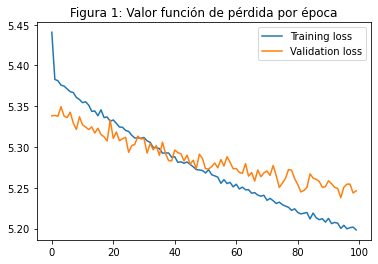

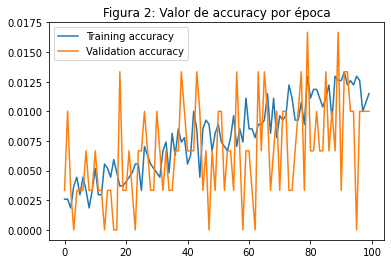

In [20]:
# ______ Primera implementación: Añadimos una sola capa totalmente conectada ___

# Las características extraídas en el paso anterior van a ser la entrada
# de un pequeño modelo de dos capas Fully Conected, donde la última será la que
# nos clasifique las clases de Caltech-UCSD (200 clases). De esta forma, es
# como si hubiéramos fijado todos los parámetros de ResNet50 y estuviésemos
# entrenando únicamente las capas añadidas. Definir dicho modelo.
# A completar: definición del modelo, del optimizador y compilación y
# entrenamiento del modelo.
# En la función fit() puedes usar el argumento validation_split

# creamos el modelo Fully Conected de una capa
modelo_una_capa_FC = Sequential(name='una_capa_FC')
modelo_una_capa_FC.add(Dense(NUM_CLASES, input_shape = INPUT ,activation = "softmax"))
# compilamos el modelo
print(modelo_una_capa_FC.summary())

modelo_una_capa_FC.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizador, metrics = ["accuracy"])
# mostramos el resultado

# guardamos los pesos iniciales por si reentrenamos
pesos_iniciales_una_FC = modelo_una_capa_FC.get_weights()
# entrenamos el modelo
evolucion = modelo_una_capa_FC.fit(caracteristicas_train, y_train, epochs = epocas, batch_size = tam_batch, validation_data = (caracteristicas_validation, y_validation), verbose = 1)
mostrarEvolucion(evolucion, 'Figura 1: Valor función de pérdida por época', 'Figura 2: Valor de accuracy por época')

Como podemos observar el valor es bastante tanto en validación como en entrenamiento son bastante malos, oscilantes y además se ha producido un sobreentrenamiento. Veamos 

Model: "Dos_capas_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_11 (Dense)            (None, 200)               205000    
                                                                 
Total params: 2,303,176
Trainable params: 2,303,176
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
14/82 [====>.........................] - ETA: 0s - loss: 5.4735 - accuracy: 0.0065  

2021-12-22 22:59:17.126355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 5.4036 - accuracy: 0.0056 - val_loss: 5.3314 - val_accuracy: 0.0100
Epoch 2/100
 8/82 [=>............................] - ETA: 0s - loss: 5.3245 - accuracy: 0.0000e+00

2021-12-22 22:59:17.862651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 5.3541 - accuracy: 0.0026 - val_loss: 5.3237 - val_accuracy: 0.0100
Epoch 3/100
82/82 [==============================] - 1s 9ms/step - loss: 5.3430 - accuracy: 0.0048 - val_loss: 5.3165 - val_accuracy: 0.0067
Epoch 4/100
82/82 [==============================] - 1s 9ms/step - loss: 5.3367 - accuracy: 0.0044 - val_loss: 5.3119 - val_accuracy: 0.0033
Epoch 5/100
82/82 [==============================] - 1s 9ms/step - loss: 5.3279 - accuracy: 0.0019 - val_loss: 5.3077 - val_accuracy: 0.0033
Epoch 6/100
82/82 [==============================] - 1s 9ms/step - loss: 5.3226 - accuracy: 0.0030 - val_loss: 5.3084 - val_accuracy: 0.0067
Epoch 7/100
82/82 [==============================] - 1s 8ms/step - loss: 5.3168 - accuracy: 0.0030 - val_loss: 5.3078 - val_accuracy: 0.0100
Epoch 8/100
82/82 [==============================] - 1s 9ms/step - loss: 5.3122 - accuracy: 0.0041 - val_loss: 5.3034 - val_accuracy: 0.0033
Epoch 9/100
82/82 [======

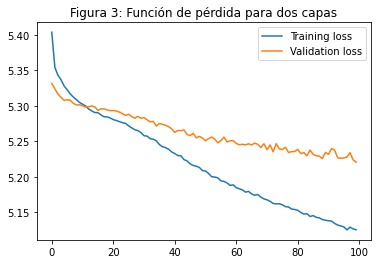

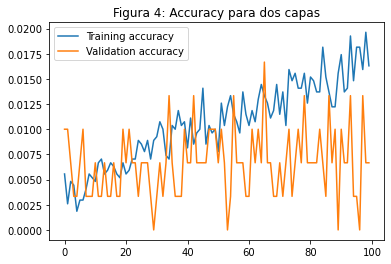

In [26]:

# Las características extraídas en el paso anterior van a ser la entrada
# de un pequeño modelo de dos capas Fully Conected, donde la última será la que
# nos clasifique las clases de Caltech-UCSD (200 clases). De esta forma, es
# como si hubiéramos fijado todos los parámetros de ResNet50 y estuviésemos
# entrenando únicamente las capas añadidas. Definir dicho modelo.
# A completar: definición del modelo, del optimizador y compilación y
# entrenamiento del modelo.
# En la función fit() puedes usar el argumento validation_split

# creamos el modelo Fully Conected de dos capas
modelo_dos_capas_FC = Sequential(name ='Dos_capas_FC')
modelo_dos_capas_FC.add(Dense(NUMERO_CARACTERISTICAS//2, activation = "relu", input_shape = INPUT))
modelo_dos_capas_FC.add(Dense(NUM_CLASES, activation = "softmax"))

# compilamos el modelo
modelo_dos_capas_FC.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizador, metrics = ["accuracy"])


# mostramos el resultado
print(modelo_dos_capas_FC.summary())


# guardamos los pesos iniciales por si reentrenamos
pesos_iniciales_FC = modelo_dos_capas_FC.get_weights()

# entrenamos el modelo
evolucion = modelo_dos_capas_FC.fit(caracteristicas_train, y_train, epochs = 100, batch_size = tam_batch, validation_data=(caracteristicas_validation, y_validation), verbose = 1)
# mostramos resultados del entrenamiento 
mostrarEvolucion(evolucion, 'Figura 3: Función de pérdida para dos capas', 'Figura 4: Accuracy para dos capas')


# Bibliografía y links de interés 

- [1] Título: *ResNet and ResNetV2*. Autor: Página oficial de keras. URL: https://keras.io/api/applications/resnet/#resnet50-function Fecha consulta: 22-12-21
- [2] Título del artículo *Deep Residual Learning for Image Recognition. Autores Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun Fecha de publicación 2005. URL: https://arxiv.org/abs/1512.03385